# **1. Import Library**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# **2. Memuat Dataset dari Hasil Clustering**

In [2]:
df = pd.read_csv('clustered_data.csv')
df

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,DBSCAN_Cluster,Cluster_Description
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08,0,Normal
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35,0,Normal
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04,0,Normal
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06,0,Normal
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,TX002508,AC00297,856.21,2023-04-26 17:09:36,Credit,Colorado Springs,D000625,21.157.41.17,M072,Branch,33,Doctor,109,1,12690.79,2024-11-04 08:11:29,0,Normal
2508,TX002509,AC00322,251.54,2023-03-22 17:36:48,Debit,Tucson,D000410,49.174.157.140,M029,Branch,48,Doctor,177,1,254.75,2024-11-04 08:11:42,0,Normal
2509,TX002510,AC00095,28.63,2023-08-21 17:08:50,Debit,San Diego,D000095,58.1.27.124,M087,Branch,56,Retired,146,1,3382.91,2024-11-04 08:08:39,0,Normal
2510,TX002511,AC00118,185.97,2023-02-24 16:24:46,Debit,Denver,D000634,21.190.11.223,M041,Online,23,Student,19,1,1776.91,2024-11-04 08:12:22,0,Normal


# **3. Data Splitting**

In [3]:
df['Fraud'] = df['DBSCAN_Cluster'].apply(lambda x: 1 if x in [-1, 1, 2, 3] else 0)

numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
categorical_cols = ['TransactionType', 'Channel', 'Location', 'CustomerOccupation']
target = 'Fraud'

X_numeric = df[numeric_cols]
X_categorical = df[categorical_cols]
y = df[target]

encoder = OneHotEncoder(sparse_output=False, drop='first')
X_categorical_encoded = encoder.fit_transform(X_categorical)

encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
X_categorical_encoded = pd.DataFrame(X_categorical_encoded, columns=encoded_feature_names)

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

X_numeric_scaled = pd.DataFrame(X_numeric_scaled, columns=numeric_cols)

processed_df = pd.concat([X_numeric_scaled, X_categorical_encoded], axis=1)

X_train, X_test, y_train, y_test = train_test_split(processed_df, y, test_size=0.3, random_state=42, stratify=y)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Fraud
0    0.953925
1    0.046075
Name: proportion, dtype: float64
Fraud
0    0.953581
1    0.046419
Name: proportion, dtype: float64


Cluster mencurigakan 1, 2, 3 dianggap sebagai fraud agar biner

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

In [4]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',random_state=42,eval_metric='logloss')

xgb_classifier.fit(X_train, y_train)

y_pred_xgb = xgb_classifier.predict(X_test)
y_prob_xgb = xgb_classifier.predict_proba(X_test)[:, 1]

tree_clf = DecisionTreeClassifier(random_state=42)
log_reg = LogisticRegression(solver='liblinear', random_state=42)

tree_clf.fit(X_train, y_train)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

#### 1. Logistic Regression.
Saya memilih Logistic Regression karena mudah diinterpretasikan dalam kasus klasifikasi biner (fraud vs normal). Data yang digunakan terdiri dari fitur numerik seperti TransactionAmount, TransactionDuration, LoginAttempts, dan AccountBalance yang telah distandardisasi menggunakan StandardScaler, serta fitur kategorikal seperti TransactionType, Channel, Location, dan CustomerOccupation yang dikonversi menggunakan One-Hot Encoding. Jika probabilitasnya lebih dari threshold tertentu (biasanya 0.5), maka transaksi diklasifikasikan sebagai fraud (1), jika kurang maka normal (0).

#### 2. Decision Tree.
Saya juga memilih Decision Tree karena interpretasinya yang mudah dan kemampuannya menangkap hubungan non-linier dalam data, yang relevan untuk deteksi fraud. Model ini menggunakan data yang telah diproses, termasuk fitur numerik seperti TransactionAmount, TransactionDuration, LoginAttempts, dan AccountBalance yang distandardisasi, serta fitur kategorikal seperti TransactionType, Channel, Location, dan CustomerOccupation yang sudah di encode menggunakan One-Hot Encoding

#### 3. XGBoost (Extreme Gradient Boosting).
Lalu memilih XGBoost karena reputasinya sebagai salah satu algoritma machine learning dengan performa tertinggi dan paling efektif, terutama dalam kompetisi dan aplikasi dunia nyata. selain itu, XGBoost memiliki mekanisme regularization yang kuat (L1 dan L2 regularization) yang membantu mencegah overfitting. XGBoost juga memiliki opsi untuk menangani imbalanced dataset secara langsung melalui parameter scale_pos_weight atau dengan menggunakan cost-sensitive learning. Karena deteksi fraud biasanya melibatkan imbalanced dataset, kemampuan XGBoost untuk mengatasi imbalance ini sangat penting

## **b. Evaluasi Model Klasifikasi**

### Model logistic regression

Evaluasi Model Klasifikasi:
Accuracy: 0.9920
Precision: 0.9677
Recall: 0.8571
F1 Score: 0.9091


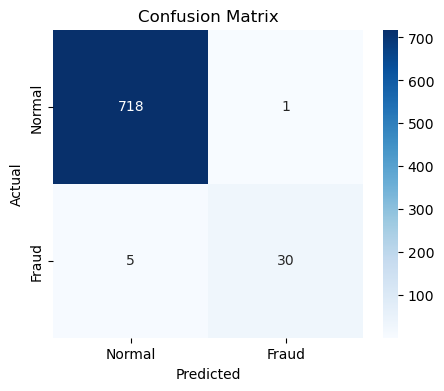


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       719
           1       0.97      0.86      0.91        35

    accuracy                           0.99       754
   macro avg       0.98      0.93      0.95       754
weighted avg       0.99      0.99      0.99       754



In [5]:
y_pred_log = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_log)
precision = precision_score(y_test, y_pred_log)
recall = recall_score(y_test, y_pred_log)
f1 = f1_score(y_test, y_pred_log)

print("Evaluasi Model Klasifikasi:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))

- Akurasi tinggi (99%) menunjukkan model sangat baik dalam memprediksi transaksi normal dan fraud
- Precision untuk Fraud (99%) berarti sebagian besar transaksi yang diklasifikasikan sebagai fraud benar adanya
- Recall untuk Fraud (86%) berarti model berhasil mendeteksi 86% transaksi fraud, namun masih ada yang terlewat
- F1-score (91%) menunjukkan keseimbangan antara precision dan recall
- Model ini memiliki presisi tinggi, sehingga hanya sedikit transaksi normal yang salah diklasifikasikan sebagai fraud

### Model decision tree

Evaluasi Model Klasifikasi:
Accuracy: 0.9934
Precision: 0.9688
Recall: 0.8857
F1 Score: 0.9254


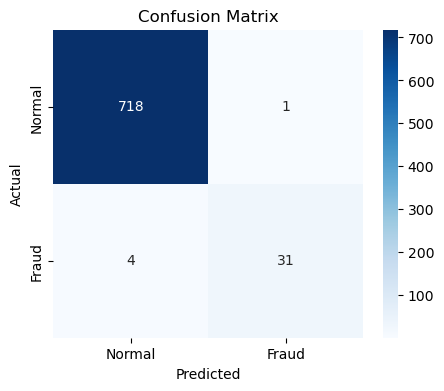

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       719
           1       0.97      0.89      0.93        35

    accuracy                           0.99       754
   macro avg       0.98      0.94      0.96       754
weighted avg       0.99      0.99      0.99       754



In [6]:
y_pred_tree = tree_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)

print("Evaluasi Model Klasifikasi:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_tree))

- Akurasi tinggi (99%) menunjukkan model sangat baik dalam memprediksi transaksi normal dan fraud
- Precision untuk Fraud (99%) berarti sebagian besar transaksi yang diklasifikasikan sebagai fraud benar adanya
- Recall untuk Fraud (89%) berarti model berhasil mendeteksi 89% transaksi fraud, namun masih ada yang terlewat seperti logistic regression
- F1-score (93%) menunjukan keseimbangan yang lebih baik antara precision dan recall untuk kelas fraud 
- Model ini memiliki presisi tinggi, sehingga hanya sedikit transaksi normal yang salah diklasifikasikan sebagai fraud

### Model XGB

Evaluasi Model Klasifikasi:
Accuracy: 0.9947
Precision: 1.0000
Recall: 0.8857
F1 Score: 0.9394


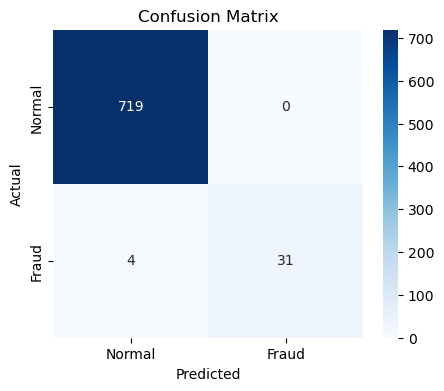

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       719
           1       1.00      0.89      0.94        35

    accuracy                           0.99       754
   macro avg       1.00      0.94      0.97       754
weighted avg       0.99      0.99      0.99       754

AUC-ROC Score (XGBoost): 0.9986091794158555


In [7]:
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print("Evaluasi Model Klasifikasi:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"AUC-ROC Score (XGBoost): {roc_auc_score(y_test, y_prob_xgb)}")

- Akurasi tinggi (99%) menunjukkan model sangat baik dalam memprediksi transaksi normal dan fraud
- Precision untuk Fraud (99%) berarti sebagian besar transaksi yang diklasifikasikan sebagai fraud benar adanya
- Recall untuk Fraud (89%) berarti model berhasil mendeteksi 89% transaksi fraud, namun masih ada yang terlewat seperti logistic regression
- F1-score (94%) menunjukan keseimbangan yang lebih baik antara precision dan recall untuk kelas fraud 
- Model ini memiliki presisi tinggi, sehingga hanya sedikit transaksi normal yang salah diklasifikasikan sebagai fraud

#### Perbandingan performa

1. Persamaan Performa:
   - Akurasi Keseluruhan Tinggi: ketiga model, yaitu Logistic Regression, Decision Tree, dan XGBoost, semuanya mencapai akurasi yang sangat tinggi, yaitu 99%. Ini menunjukkan bahwa ketiganya secara umum sangat efektif dalam mengklasifikasikan transaksi menjadi kelas normal dan fraud pada dataset ini
   - Precision untuk Fraud Tinggi: Ketiga model juga menunjukkan precision yang sangat tinggi untuk kelas '0' (Normal), yaitu 0.99 (atau 99%). Ini berarti ketiganya sangat andal dalam memprediksi transaksi normal, dan memiliki tingkat false positive yang sangat rendah untuk kelas normal (atau false negative yang rendah untuk kelas fraud, dari perspektif kelas normal)
2. Perbedaan Performa yang Signifikan (Meskipun Kecil dalam Angka):
   - Recall untuk Fraud Tertinggi pada Decision Tree (89%) dan XGBoost (89%):  Dalam hal recall untuk kelas '1' (Fraud), baik Decision Tree maupun XGBoost mencapai nilai yang sama, yaitu 89%. Ini sedikit lebih tinggi dibandingkan Logistic Regression (86%). Recall 89% berarti Decision Tree dan XGBoost sama-sama berhasil mendeteksi 89% dari seluruh transaksi fraud yang sebenarnya terjadi di dataset test
   - F1-score untuk Fraud Tertinggi pada XGBoost (94%):  Sebagai kombinasi dari precision dan recall, F1-score untuk kelas '1' (Fraud) juga tertinggi pada XGBoost, yaitu 94%. Ini sedikit lebih tinggi dibandingkan Decision Tree (93%) dan Logistic Regression (91%). F1-score yang lebih tinggi pada XGBoost mengkonfirmasi bahwa model ini menawarkan keseimbangan terbaik antara precision dan recall untuk deteksi fraud dibandingkan kedua model lainnya

## **c. Tuning Model Klasifikasi (Optional)**

Karena saya rasa performa model sudah cukup baik dengan akurasi 99% dan F1-score yang tinggi untuk kedua kelas, tuning model tidak dilakukan.

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Tidak ada perubahan model atau evaluasi ulang setelah tuning

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

1. Evaluasi Performa Model:
   - Decision Tree sedikit dan XGB lebih unggul dibandingkan Logistic Regression, terutama dalam hal Recall dan F1-score untuk kelas fraud. Ini berarti Decision Tree dan XGB sedikit lebih efektif dalam mendeteksi transaksi fraud yang sebenarnya, dengan false negative yang lebih sedikit, dan mencapai keseimbangan yang lebih baik antara precision dan recall
2. Potensi Kelemahan Model:
   - Recall untuk Kelas Fraud Masih di Bawah Sempurna: Walaupun recall Decision Tree dan XGB lebih baik (89%), ini berarti masih ada sekitar 11% transaksi fraud yang tidak terdeteksi (false negative)
3. Rekomendasi Perbaikan:
   - Mengumpulkan lebih banyak data terkait transaksi fraud bisa membantu model mengenali pola fraud lebih baik